Using device: cuda


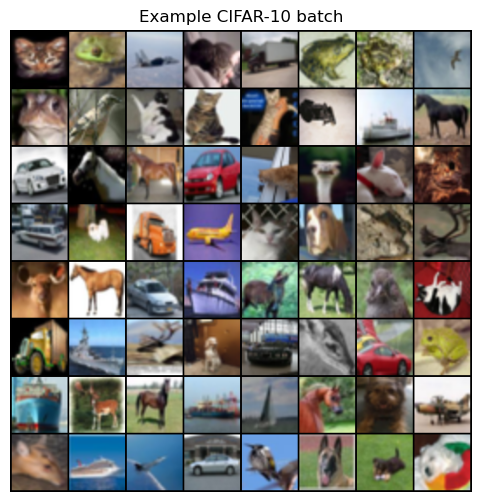

In [1]:
import os
from dataclasses import dataclass
from typing import List

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
from torchvision.models.inception import inception_v3, Inception_V3_Weights
import matplotlib.pyplot as plt
from scipy import linalg

%matplotlib inline

torch.backends.cudnn.benchmark = True


@dataclass
class DCGANConfig:
    epochs: int = 50
    batch_size: int = 128
    lr: float = 2e-4
    beta1: float = 0.5
    beta2: float = 0.999
    z_dim: int = 100
    image_size: int = 64
    channels: int = 3
    g_feat: int = 64
    d_feat: int = 64
    fid_samples: int = 2048  # real/fake samples for FID


cfg = DCGANConfig()


def set_seed(seed: int = 42) -> None:
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

RESULTS_DIR = "DCGAN_results"
os.makedirs(os.path.join(RESULTS_DIR, "GeneratedImages"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "RealImages"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "Metrics"), exist_ok=True)

# CIFAR-10 data pipeline
transform = transforms.Compose([
    transforms.Resize(cfg.image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=True,
    transform=transform,
)

train_loader = DataLoader(
    train_set,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

# Sanity check: show a sample batch
real_batch = next(iter(train_loader))
plt.figure(figsize=(8, 6))
plt.axis("off")
plt.title("Example CIFAR-10 batch")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0][:64], padding=2, normalize=True),
        (1, 2, 0),
    )
)
plt.show()


In [2]:
class Generator(nn.Module):
    """DCGAN generator for 64x64 RGB images."""
    def __init__(self, z_dim: int, base_channels: int, img_channels: int):
        super().__init__()
        self.net = nn.Sequential(
            self._block(z_dim, base_channels * 8, 4, 1, 0),
            self._block(base_channels * 8, base_channels * 4, 4, 2, 1),
            self._block(base_channels * 4, base_channels * 2, 4, 2, 1),
            self._block(base_channels * 2, base_channels, 4, 2, 1),
            nn.ConvTranspose2d(base_channels, img_channels, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    @staticmethod
    def _block(in_c: int, out_c: int, k: int, s: int, p: int) -> nn.Sequential:
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, k, s, p, bias=False),
            nn.BatchNorm2d(out_c, momentum=0.9),
            nn.ReLU(True),
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.net(z)


class Discriminator(nn.Module):
    """DCGAN discriminator for 64x64 RGB images."""
    def __init__(self, img_channels: int, base_channels: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, base_channels, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            self._block(base_channels, base_channels * 2, 4, 2, 1),
            self._block(base_channels * 2, base_channels * 4, 4, 2, 1),
            self._block(base_channels * 4, base_channels * 8, 4, 2, 1),

            nn.Conv2d(base_channels * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    @staticmethod
    def _block(in_c: int, out_c: int, k: int, s: int, p: int) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, k, s, p, bias=False),
            nn.BatchNorm2d(out_c, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


def init_weights(module: nn.Module) -> None:
    """DCGAN-style weight initialization."""
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(module.weight.data, 0.0, 0.02)
        if getattr(module, "bias", None) is not None:
            nn.init.zeros_(module.bias.data)


G = Generator(cfg.z_dim, cfg.g_feat, cfg.channels).to(device)
D = Discriminator(cfg.channels, cfg.d_feat).to(device)
G.apply(init_weights)
D.apply(init_weights)

print(G)
print(D)


Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [3]:
class FIDEvaluator(nn.Module):
    """Computes FID between real and fake images using Inception-v3 features."""
    def __init__(self, device: torch.device):
        super().__init__()
        weights = Inception_V3_Weights.IMAGENET1K_V1

        # Do NOT pass aux_logits=False when using weights; let it default.
        inception = inception_v3(
            weights=weights,
            transform_input=False,   # keep images as-is; we'll normalize ourselves
        )

        # We only need feature vectors, not the final classifier
        inception.fc = nn.Identity()
        self.inception = inception.to(device).eval()

        for p in self.inception.parameters():
            p.requires_grad_(False)

        self.device = device

    @torch.no_grad()
    def _features(self, imgs: torch.Tensor) -> np.ndarray:
        # imgs expected in [-1, 1]
        imgs = (imgs + 1) / 2  # map to [0, 1]
        imgs = F.interpolate(
            imgs, size=(299, 299),
            mode="bilinear", align_corners=False
        )

        out = self.inception(imgs.to(self.device))

        # With aux_logits=True, torchvision returns an InceptionOutputs namedtuple.
        # First element is the main logits/features; ignore aux output.
        if isinstance(out, tuple):
            out = out[0]

        feats = out
        return feats.cpu().numpy()

    def _stats(self, feats: np.ndarray):
        mu = np.mean(feats, axis=0)
        sigma = np.cov(feats, rowvar=False)
        return mu, sigma

    def forward(self, real: torch.Tensor, fake: torch.Tensor) -> float:
        real_f = self._features(real)
        fake_f = self._features(fake)
        mu1, sigma1 = self._stats(real_f)
        mu2, sigma2 = self._stats(fake_f)

        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = np.sum((mu1 - mu2) ** 2) + np.trace(
            sigma1 + sigma2 - 2 * covmean
        )
        return float(fid)


fid_evaluator = FIDEvaluator(device)

criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))
opt_D = optim.Adam(D.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))

fixed_noise = torch.randn(64, cfg.z_dim, 1, 1, device=device)


In [4]:
def save_image_grid(tensor: torch.Tensor, path: str, title: str = "") -> None:
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    if title:
        plt.title(title)
    grid = vutils.make_grid(tensor, padding=2, normalize=True)
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.savefig(path, bbox_inches="tight")
    plt.close()


def plot_training_curves(epochs: List[int],
                         g_losses: List[float],
                         d_losses: List[float],
                         acc: List[float],
                         fid_scores: List[float]) -> None:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Losses
    axes[0].plot(epochs, g_losses, label="Generator")
    axes[0].plot(epochs, d_losses, label="Discriminator")
    axes[0].set_title("Network Losses")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # FID
    axes[1].plot(epochs, fid_scores)
    axes[1].set_title("Quality Metrics")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("FID Score")

    # Discriminator accuracy
    axes[2].plot(epochs, acc)
    axes[2].set_title("Discriminator Performance")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Accuracy (%)")

    plt.tight_layout()
    out_path = os.path.join(RESULTS_DIR, "Metrics", "training_curves.png")
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()
    


In [5]:
epoch_ids: List[int] = []
g_history: List[float] = []
d_history: List[float] = []
acc_history: List[float] = []
fid_history: List[float] = []

# Track best (lowest) FID and corresponding weights
best_fid = float("inf")
best_epoch = -1
best_G_state = None
best_D_state = None

print("Starting training...")
for epoch in range(cfg.epochs):
    G.train()
    D.train()

    running_g_loss = 0.0
    running_d_loss = 0.0
    correct = 0
    total = 0

    real_samples_for_fid = []
    fake_samples_for_fid = []

    for batch_idx, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        bsz = real_imgs.size(0)

        # --- Train Discriminator ---
        D.zero_grad(set_to_none=True)
        real_labels = torch.full((bsz,), 1.0, device=device)
        fake_labels = torch.full((bsz,), 0.0, device=device)

        out_real = D(real_imgs).view(-1)
        loss_real = criterion(out_real, real_labels)

        noise = torch.randn(bsz, cfg.z_dim, 1, 1, device=device)
        fake_imgs = G(noise)
        out_fake = D(fake_imgs.detach()).view(-1)
        loss_fake = criterion(out_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        opt_D.step()

        # Discriminator accuracy (real->1, fake->0)
        preds_real = (out_real >= 0.5).float()
        preds_fake = (out_fake < 0.5).float()
        correct += preds_real.sum().item() + preds_fake.sum().item()
        total += 2 * bsz

        # --- Train Generator ---
        G.zero_grad(set_to_none=True)
        out_fake_for_G = D(fake_imgs).view(-1)
        loss_G = criterion(out_fake_for_G, real_labels)  # want D(fake)=1
        loss_G.backward()
        opt_G.step()

        running_g_loss += loss_G.item()
        running_d_loss += loss_D.item()

        # Collect subset for FID computation
        if batch_idx < 5:
            real_samples_for_fid.append(real_imgs.detach())
            fake_samples_for_fid.append(fake_imgs.detach())

    avg_g = running_g_loss / len(train_loader)
    avg_d = running_d_loss / len(train_loader)
    disc_acc = 100.0 * correct / max(1, total)

    # Compute FID for this epoch
    with torch.no_grad():
        real_pool = torch.cat(real_samples_for_fid, dim=0)[: cfg.fid_samples]
        fake_pool = torch.cat(fake_samples_for_fid, dim=0)[: cfg.fid_samples]
        fid_value = fid_evaluator(real_pool, fake_pool)

    epoch_ids.append(epoch + 1)
    g_history.append(avg_g)
    d_history.append(avg_d)
    acc_history.append(disc_acc)
    fid_history.append(fid_value)

    # Keep track of the best generator according to FID
    if fid_value < best_fid:
        best_fid = fid_value
        best_epoch = epoch + 1
        best_G_state = G.state_dict()
        best_D_state = D.state_dict()

    print(
        f"Epoch [{epoch+1}/{cfg.epochs}]  "
        f"D_loss: {avg_d:.4f}  G_loss: {avg_g:.4f}  "
        f"Acc: {disc_acc:5.2f}%  FID: {fid_value:.2f}"
    )

    # Save generated samples every few epochs
    if (epoch + 1) % 5 == 0 or epoch + 1 == cfg.epochs:
        G.eval()
        with torch.no_grad():
            fake_fixed = G(fixed_noise).cpu()
        save_image_grid(
            fake_fixed,
            os.path.join(
                RESULTS_DIR,
                "GeneratedImages",
                f"epoch_{epoch+1:03d}.png",
            ),
            title=f"Generated Images at Epoch {epoch+1}",
        )

print("Training loop finished")
print(f"Best FID {best_fid:.2f} observed at epoch {best_epoch}")


Starting training...
Epoch [1/50]  D_loss: 0.2079  G_loss: 4.3323  Acc: 97.93%  FID: 440.92
Epoch [2/50]  D_loss: 0.6159  G_loss: 3.6404  Acc: 88.45%  FID: 409.73
Epoch [3/50]  D_loss: 0.8126  G_loss: 2.4857  Acc: 82.38%  FID: 306.95
Epoch [4/50]  D_loss: 0.7731  G_loss: 2.3587  Acc: 85.21%  FID: 201.08
Epoch [5/50]  D_loss: 0.7604  G_loss: 2.4737  Acc: 84.15%  FID: 157.15
Epoch [6/50]  D_loss: 0.8113  G_loss: 2.3763  Acc: 83.37%  FID: 126.38
Epoch [7/50]  D_loss: 0.7865  G_loss: 2.3378  Acc: 84.65%  FID: 109.35
Epoch [8/50]  D_loss: 0.7753  G_loss: 2.3887  Acc: 85.11%  FID: 113.09
Epoch [9/50]  D_loss: 0.7594  G_loss: 2.3853  Acc: 84.85%  FID: 113.66
Epoch [10/50]  D_loss: 0.7828  G_loss: 2.3179  Acc: 84.42%  FID: 107.39
Epoch [11/50]  D_loss: 0.7440  G_loss: 2.3781  Acc: 85.16%  FID: 104.16
Epoch [12/50]  D_loss: 0.7605  G_loss: 2.4067  Acc: 84.97%  FID: 98.67
Epoch [13/50]  D_loss: 0.7473  G_loss: 2.3847  Acc: 85.57%  FID: 93.18
Epoch [14/50]  D_loss: 0.6985  G_loss: 2.6297  Acc: 86

Final Metrics:
Generator Loss: 3.8849
Discriminator Loss: 0.3566
Discriminator Accuracy: 94.64%
Quality Score: 72.6433


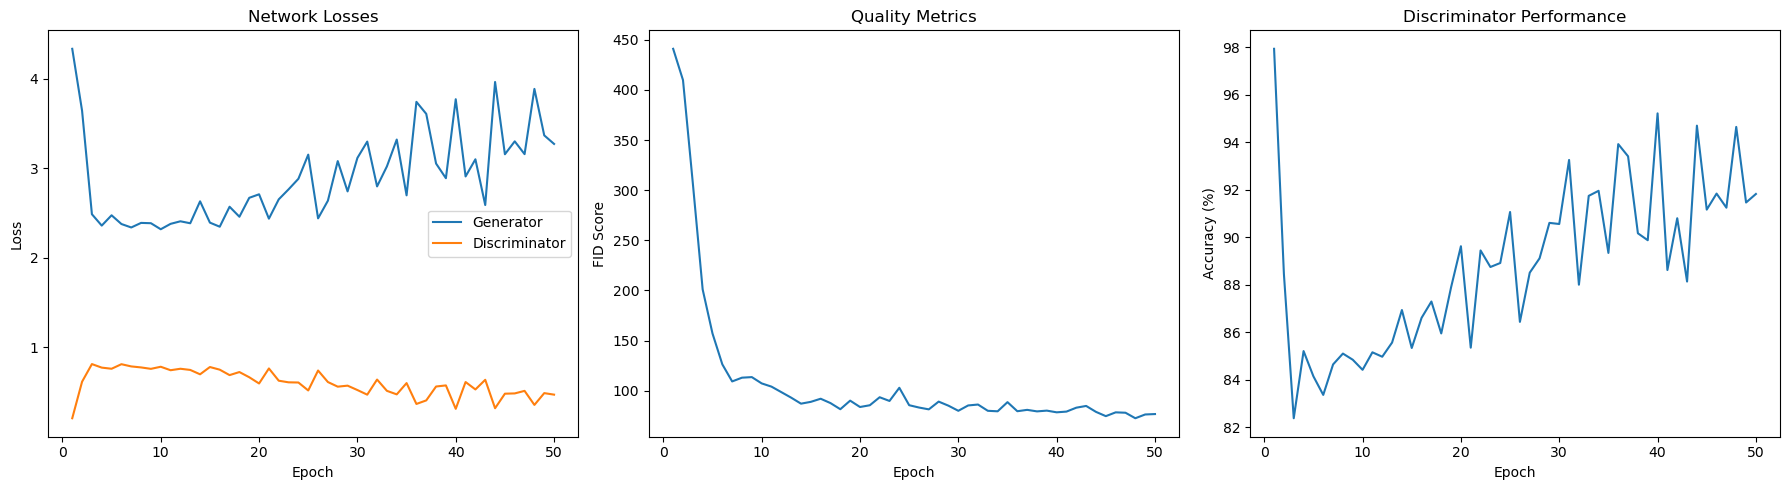

Saved training curves to DCGAN_results/Metrics/training_curves.png


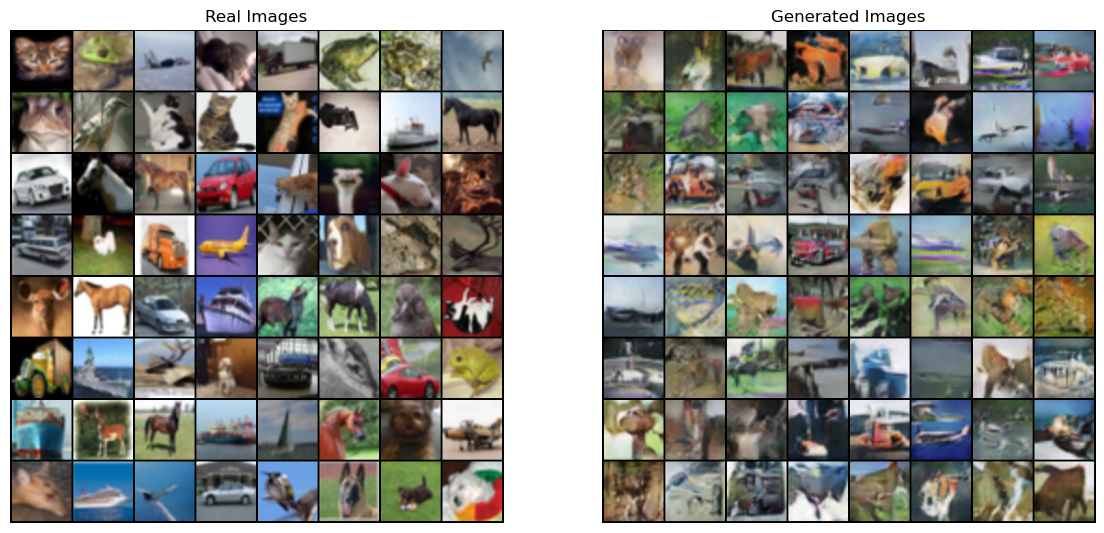


 saved results in DCGAN_results directory


In [8]:
if best_epoch == -1:
    best_epoch = epoch_ids[-1]
    best_fid = fid_history[-1]
    best_G_state = G.state_dict()
    best_D_state = D.state_dict()

# Load the best model weights
if best_G_state is not None:
    G.load_state_dict(best_G_state)
if best_D_state is not None:
    D.load_state_dict(best_D_state)

best_idx = epoch_ids.index(best_epoch)

final_gen_loss = g_history[best_idx]
final_disc_loss = d_history[best_idx]
final_disc_acc = acc_history[best_idx]
final_fid = fid_history[best_idx]

print("Final Metrics:")
print(f"Generator Loss: {final_gen_loss:.4f}")
print(f"Discriminator Loss: {final_disc_loss:.4f}")
print(f"Discriminator Accuracy: {final_disc_acc:.2f}%")
print(f"Quality Score: {final_fid:.4f}")

# Save training curves
plot_training_curves(epoch_ids, g_history, d_history, acc_history, fid_history)

# Produce side-by-side final images
real_grid = vutils.make_grid(real_batch[0][:64], padding=2, normalize=True)
with torch.no_grad():
    fake_grid = vutils.make_grid(G(fixed_noise).cpu(), padding=2, normalize=True)

# Save individual images
save_image_grid(real_batch[0][:64].cpu(),
                os.path.join(RESULTS_DIR, "RealImages", "real_grid.png"),
                title="Real Images")
save_image_grid(G(fixed_noise).cpu(),
                os.path.join(RESULTS_DIR, "GeneratedImages", "fake_grid_final.png"),
                title="Generated Images")

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.title("Real Images")
plt.axis("off")
plt.imshow(np.transpose(real_grid, (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.title("Generated Images")
plt.axis("off")
plt.imshow(np.transpose(fake_grid, (1, 2, 0)))

# Save combined figure
combined_path = os.path.join(RESULTS_DIR, "combined_final.png")
plt.savefig(combined_path, bbox_inches="tight")
plt.show()

print("\n saved results in DCGAN_results directory")
